In this report, I will introduce to graph convolutional networks (GCNs), and illustrate how information is propagated through the hidden layers of a GCN, using coding examples. We will see how this mechanism produces useful feature representations of nodes in graphs. 

## What is a graph convolutional network? 

GCNs are neural network architectures dedicated for machine learning on __graphs__. 

![](karate.png "GCN example")

Given a graph G = (V, E), a GCN takes as input: 

1. an input feature matrix $N \times F^0$, X, where $N$ is the number of nodes, and
 $F^0$ is the number of input features for each node, 

2. an $N \times N$ matrix representation of the graph structure, such as the adjacency
 matrix. 

A hidden layer in the GCN can be written as $H^i = f(H^{i-1}, A)$, where $H^0 = X$, 
 and $f$ is a propagation. Each layer $H^i$ corresponds to an $N \times F^i$ feature
 matrix, where each row is a feature representation of a node. At each layer, these
 features are aggregated to form the nex layer's features, using the propagation
 rule $f$. Features become increasingly abstract at each consecutive layer (doesn't
 this sound familiar?) In this framework, variants of GCN differ only in the choice
 of propagation rule $f$. 
 
## A simple propagation rule

One of the simplest possible propagation rule is \[1\]:

$f(H^i, A) = \sigma(AH^iW^i)$

where $W^i$ is the weight matrix for layer $i$ and $\sigma$ is a non-linear activation function such as 
the RELU activation. The weight matrix has dimensions $F^i \times F^{i+1}$. 
In other words, the size of the 2nd dimension of the weight matrix 
determines the number of features at the next layer. If you are familiar with 
convolutional neural networks, this operation is similar to a filtering 
operation, since these weights are shared across nodes in the graph. 
 
## A simple graph example

As a simple example, we shall see the following graph: 

![](dir_graph.png "A simple directed graph")

A below is its numpy adjacency matrix representation. 

In [1]:
import numpy as np 

A = np.array([
    [0,1,0,0],
    [0,0,1,1],
    [0,1,0,0],
    [1,0,1,0],
], dtype=np.float32)

Next, we need features! We generate 2 integer features for every node based on its index. 
This makes it easy to confirm the matrix calculations manually later.

In [2]:
X = np.array([
    [i,-i]
    for i in range(A.shape[0])
], dtype=np.float32);X

array([[ 0.,  0.],
       [ 1., -1.],
       [ 2., -2.],
       [ 3., -3.]], dtype=float32)

## Applying the propagation rule

Alright! We now have a graph, of which the adjacency matrix $A$ and a set of input
features $X$. Let's see what happens when we apply the propagation rule: 

In [3]:
np.matmul(A, X)

array([[ 1., -1.],
       [ 5., -5.],
       [ 1., -1.],
       [ 2., -2.]], dtype=float32)

What happened? __The representation of each node (each row) is now a sum of 
its neighbours' features!__ In other words, the graph convolutional layer 
represents each node as an aggregate of its neighbourhood. Note that in this
case a node $n$ is a neighbour of node $v$ if there exists an edge between
$v$ and $n$. 

## Problems on the horizon

You may have already spotted the problems:

The aggregated representation of a node does not include its own features! 
The representation is an aggregate of the features of neighbor nodes, so 
only nodes that has a self-loop will include their own features in the 
aggregate.\[1\]

Nodes with large degrees will have large values in their feature representation 
while nodes with small degrees will have small values. This can cause vanishing 
or exploding gradients \[1, 2\], but is also problematic for stochastic gradient 
descent algorithms which are typically used to train such networks and are 
sensitive to the scale (or range of values) of each of the input features.
In the following, I discuss each of these problems separately.

## Adding self-loops

To address the first problem, one can simply add a self-loop to each node 
\[1, 2\]. In practice this is done by adding the identity matrix $I$ to 
the adjacency matrix $A$ before applying the propagation rule.

In [4]:
I = np.array(np.eye(A.shape[0])); I 

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [5]:
A_hat = A + I

In [6]:
np.matmul(A_hat, X)

array([[ 1., -1.],
       [ 6., -6.],
       [ 3., -3.],
       [ 5., -5.]])

Since the node is now a neighbor of itself, the node’s own features is 
included when summing up the features of its neighbors!

## Normalizing the feature representations

The feature representations can be normalized by node degree by 
transforming the adjacency matrix A by multiplying it with the 
inverse degree matrix $D$ \[1\]. Thus our simplified propagation 
rule looks like this \[1\]:

$f(X, A) = D^{-1}AX$

Let's see what happens. We first compute the degree matrix. 

In [7]:
D = np.array(np.sum(A, axis=0))
D = np.diag(D); D

array([[1., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 1.]], dtype=float32)

Before applying the rule, let's see what happens to the adjacency matrix after we transform it. 

Before: 

In [8]:
A

array([[0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 1., 0., 0.],
       [1., 0., 1., 0.]], dtype=float32)

After: 

In [9]:
np.matmul(np.linalg.inv(D), A)

array([[0. , 1. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5],
       [0. , 0.5, 0. , 0. ],
       [1. , 0. , 1. , 0. ]], dtype=float32)

Observe that the weights (the values) in each row of the adjacency matrix 
have been divided by the degree of the node corresponding to the row. 
We apply the propagation rule with the transformed adjacency matrix

In [10]:
np.matmul(np.matmul(np.linalg.inv(D), A), X)

array([[ 1. , -1. ],
       [ 2.5, -2.5],
       [ 0.5, -0.5],
       [ 2. , -2. ]], dtype=float32)

and get node representations corresponding to the mean of the features of 
neighboring nodes. This is because the weights in the (transformed) adjacency 
matrix correspond to weights in a weighted sum of the neighboring nodes' features. 
Again, I encourage you to verify this observation for yourself.

## Putting it all together

We now combine the self-loop and normalization tips. In addition, 
we’ll reintroduce the weights and activation function that we 
previously discarded to simplify the discussion.

### Adding back the Weights

First order of business is applying the weights. Note that here $D_{hat}$ 
is the degree matrix of $A_{hat} = A + I$, i.e., the degree matrix of $A$ 
with forced self-loops.

In [11]:
W = np.array([
    [1, -1], 
    [-1, 1]
])

D_hat = np.array(np.sum(A_hat, axis=0))
D_hat = np.diag(D_hat)

np.matmul(np.matmul(np.matmul(np.linalg.inv(D_hat), A_hat), X), W)

array([[ 1., -1.],
       [ 4., -4.],
       [ 2., -2.],
       [ 5., -5.]])

And if we want to reduce the dimensionality of the output feature representations 
we can reduce the size of the weight matrix $W$:

In [12]:
W = np.array([[1], [-1]])

np.matmul(np.matmul(np.matmul(np.linalg.inv(D_hat), A_hat), X), W)

array([[1.],
       [4.],
       [2.],
       [5.]])

## Adding an activation function

We choose to preserve the dimensionality of the feature representations
and apply the RELU activation function.

In [13]:
W = np.array([
    [1, -1], 
    [-1, 1]
])

def relu(x):
    return np.where(x > 0, x, 0)

In [14]:
relu(np.matmul(np.matmul(np.matmul(np.linalg.inv(D_hat), A_hat), X), W))

array([[1., 0.],
       [4., 0.],
       [2., 0.],
       [5., 0.]])

### Voila! A complete hidden layer with adjacency matrix, input features, weights and activation function! 

## Back to reality

Now, finally, we can apply a graph convolutional network on a real graph. 
I will show you how to produce the feature representations we saw early in the post.

### Zachary’s Karate Club

Zachary’s karate club is a commonly used social network where nodes represent members 
of a karate club and the edges their mutual relations. While Zachary was studying the 
karate club, a conflict arose between the administrator and the instructor 
which resulted in the club splitting in two. The figure below shows the graph representation 
of the network and nodes are labeled according to which part of the club. 
The administrator and instructor are marked with $A$ and $I$, respectively.

![](club.png "Zachary's karate club")

### Building the GCN

Now let us build the graph convolutional network. We won’t actually train the network, 
but simply initialize it at random to produce the feature representations we saw at 
the start of this post. We will use networkx which has a graph representation of 
the club easily available, and compute the $A_{hat}$ and $D_{hat}$ matrices.

In [15]:
from networkx import karate_club_graph, to_numpy_array
import networkx as nx

In [16]:
zkc = karate_club_graph()

In [17]:
clubs = [zkc.nodes[f]['club'] for f in zkc.nodes]
# get node colors based on clubs
node_colors = [int(c == "Officer") for c in clubs]

In [18]:
order = sorted(list(zkc.nodes()))

In [19]:
A = to_numpy_array(zkc, nodelist=order); A

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [20]:
I = np.eye(zkc.number_of_nodes())

A_hat = A + I 

D_hat = np.sum(A_hat, axis=0)
D_hat = np.diag(D_hat); D_hat

array([[17.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 10.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 11., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  7.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 13.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 18.]])

Next, we'ill initialize weights randomly.

In [21]:
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 4))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))

Stack the GCN layers. We here use just the identity matrix as feature representation, 
that is, each node is represented as a one-hot encoded categorical variable.

In [22]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

In [23]:
def gcn_layer(A_hat, D_hat, X, W, activation='relu'):
    if activation == 'relu':
        return relu(np.matmul(np.matmul(np.matmul(np.linalg.inv(D_hat), A_hat), X), W))
    if activation == 'sigmoid':
        return sigmoid(np.matmul(np.matmul(np.matmul(np.linalg.inv(D_hat), A_hat), X), W))
    
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2, 'sigmoid')
output = H_2; output

array([[0.4187601 , 0.37015253],
       [0.45279497, 0.3747409 ],
       [0.44929962, 0.38392331],
       [0.41788463, 0.31467286],
       [0.4759484 , 0.45636467],
       [0.47619382, 0.43808203],
       [0.49959083, 0.46030267],
       [0.49392658, 0.35355612],
       [0.39662974, 0.3761771 ],
       [0.4389606 , 0.42936905],
       [0.45606653, 0.43731057],
       [0.34272071, 0.2768507 ],
       [0.38570538, 0.28964696],
       [0.44018866, 0.36323722],
       [0.40028648, 0.40343586],
       [0.36338478, 0.35903943],
       [0.49259201, 0.45406564],
       [0.50780881, 0.43017605],
       [0.40008829, 0.40408006],
       [0.46923037, 0.4130185 ],
       [0.37917931, 0.38215187],
       [0.47665718, 0.3936122 ],
       [0.30617391, 0.31316885],
       [0.43151892, 0.43324478],
       [0.49790578, 0.49799161],
       [0.4900914 , 0.49049743],
       [0.4004998 , 0.40242232],
       [0.45751552, 0.4538356 ],
       [0.45470621, 0.44979476],
       [0.39808173, 0.40091906],
       [0.

We extract the feature representations.

In [24]:
feature_representations = {
    node: np.array(output)[node] 
    for node in zkc.nodes()}; feature_representations

{0: array([0.4187601 , 0.37015253]),
 1: array([0.45279497, 0.3747409 ]),
 2: array([0.44929962, 0.38392331]),
 3: array([0.41788463, 0.31467286]),
 4: array([0.4759484 , 0.45636467]),
 5: array([0.47619382, 0.43808203]),
 6: array([0.49959083, 0.46030267]),
 7: array([0.49392658, 0.35355612]),
 8: array([0.39662974, 0.3761771 ]),
 9: array([0.4389606 , 0.42936905]),
 10: array([0.45606653, 0.43731057]),
 11: array([0.34272071, 0.2768507 ]),
 12: array([0.38570538, 0.28964696]),
 13: array([0.44018866, 0.36323722]),
 14: array([0.40028648, 0.40343586]),
 15: array([0.36338478, 0.35903943]),
 16: array([0.49259201, 0.45406564]),
 17: array([0.50780881, 0.43017605]),
 18: array([0.40008829, 0.40408006]),
 19: array([0.46923037, 0.4130185 ]),
 20: array([0.37917931, 0.38215187]),
 21: array([0.47665718, 0.3936122 ]),
 22: array([0.30617391, 0.31316885]),
 23: array([0.43151892, 0.43324478]),
 24: array([0.49790578, 0.49799161]),
 25: array([0.4900914 , 0.49049743]),
 26: array([0.4004998 

And voila! Feature representations that separate the communities in Zachary’s 
karate club quite well. And we haven’t even begun training yet!

In [25]:
import matplotlib.pyplot as plt

%matplotlib inline

/home/test/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


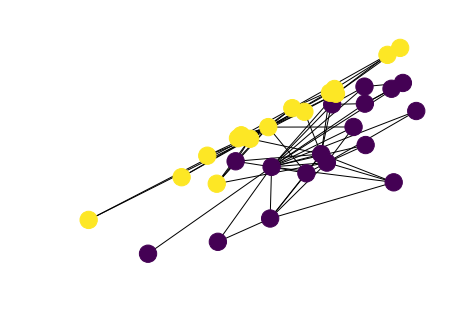

In [26]:
nx.draw(zkc, pos=output, node_color=node_colors)